In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.sparse import csr_matrix, hstack
from nltk.corpus import stopwords
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
import warnings
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, ElasticNet

warnings.filterwarnings("ignore")
import gc
%matplotlib inline

This jupyter notebook aims to use text data and metadata about wine to create a regression model in which we predict the points a wine taster gives to a specific wine. The dataset comes with information regarding the country, province, region, who the taster is, data about the wine itself, etc.

### Read in Data

In [2]:
winereviews = pd.read_csv('winemag-data-130k-v2.csv').drop('Unnamed: 0',axis=1)


### Data Visualization

When we build a regression model we want to explore the data in its entireity. For this part of the jupyter notebook, I will visualize the data before preprocessing.

Text(0.5,1,'Does Price Imply Better Wine? $r$=0.612')

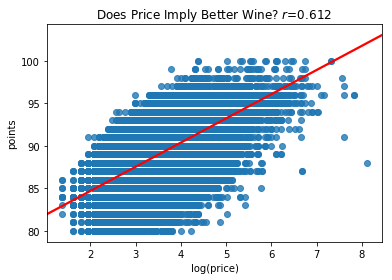

In [3]:
# correlation between points and price
slope, intercept, r_value, p_value, std_err = linregress(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])])

sns.regplot(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])],line_kws={"color":"r"})
plt.xlabel('log(price)')
plt.title(f'Does Price Imply Better Wine? $r$={round(r_value,3)}')

A common idea is that the more expensive the bottle of wine is the better the wine itself is. Here I explore and can confirm this trend. There is a clear correlation between the log of the price of wine and the points the reviewer gives. However, if we square the r-value (otherwise known as pearson's correlation coefficient) the $r^2$ is much lower. This is supported qualitatively by the model. Even though there is a positive trend, the data is not fit well by the line.

I plot two quantitative variables here: the natural log of the price and the points variable. When plotting two quantitative variables the best encoding is to use a scatterplot, as we can effectively display the relationship between two quantitative variables that way. The mark used to show (log(price),points) is a point. The channel we use is position for the points as we want to compare how the changes in price affect the points. I also plot a regression line to show the trend of the data. I use the color red to encode the line in order to avoid occlusion. The mark we use here is a line and the channel we encode is also position as we want to see how the trend line behaves as one moves up or down the x-axis.

Text(0.5,1,'Where are the best wines located?')

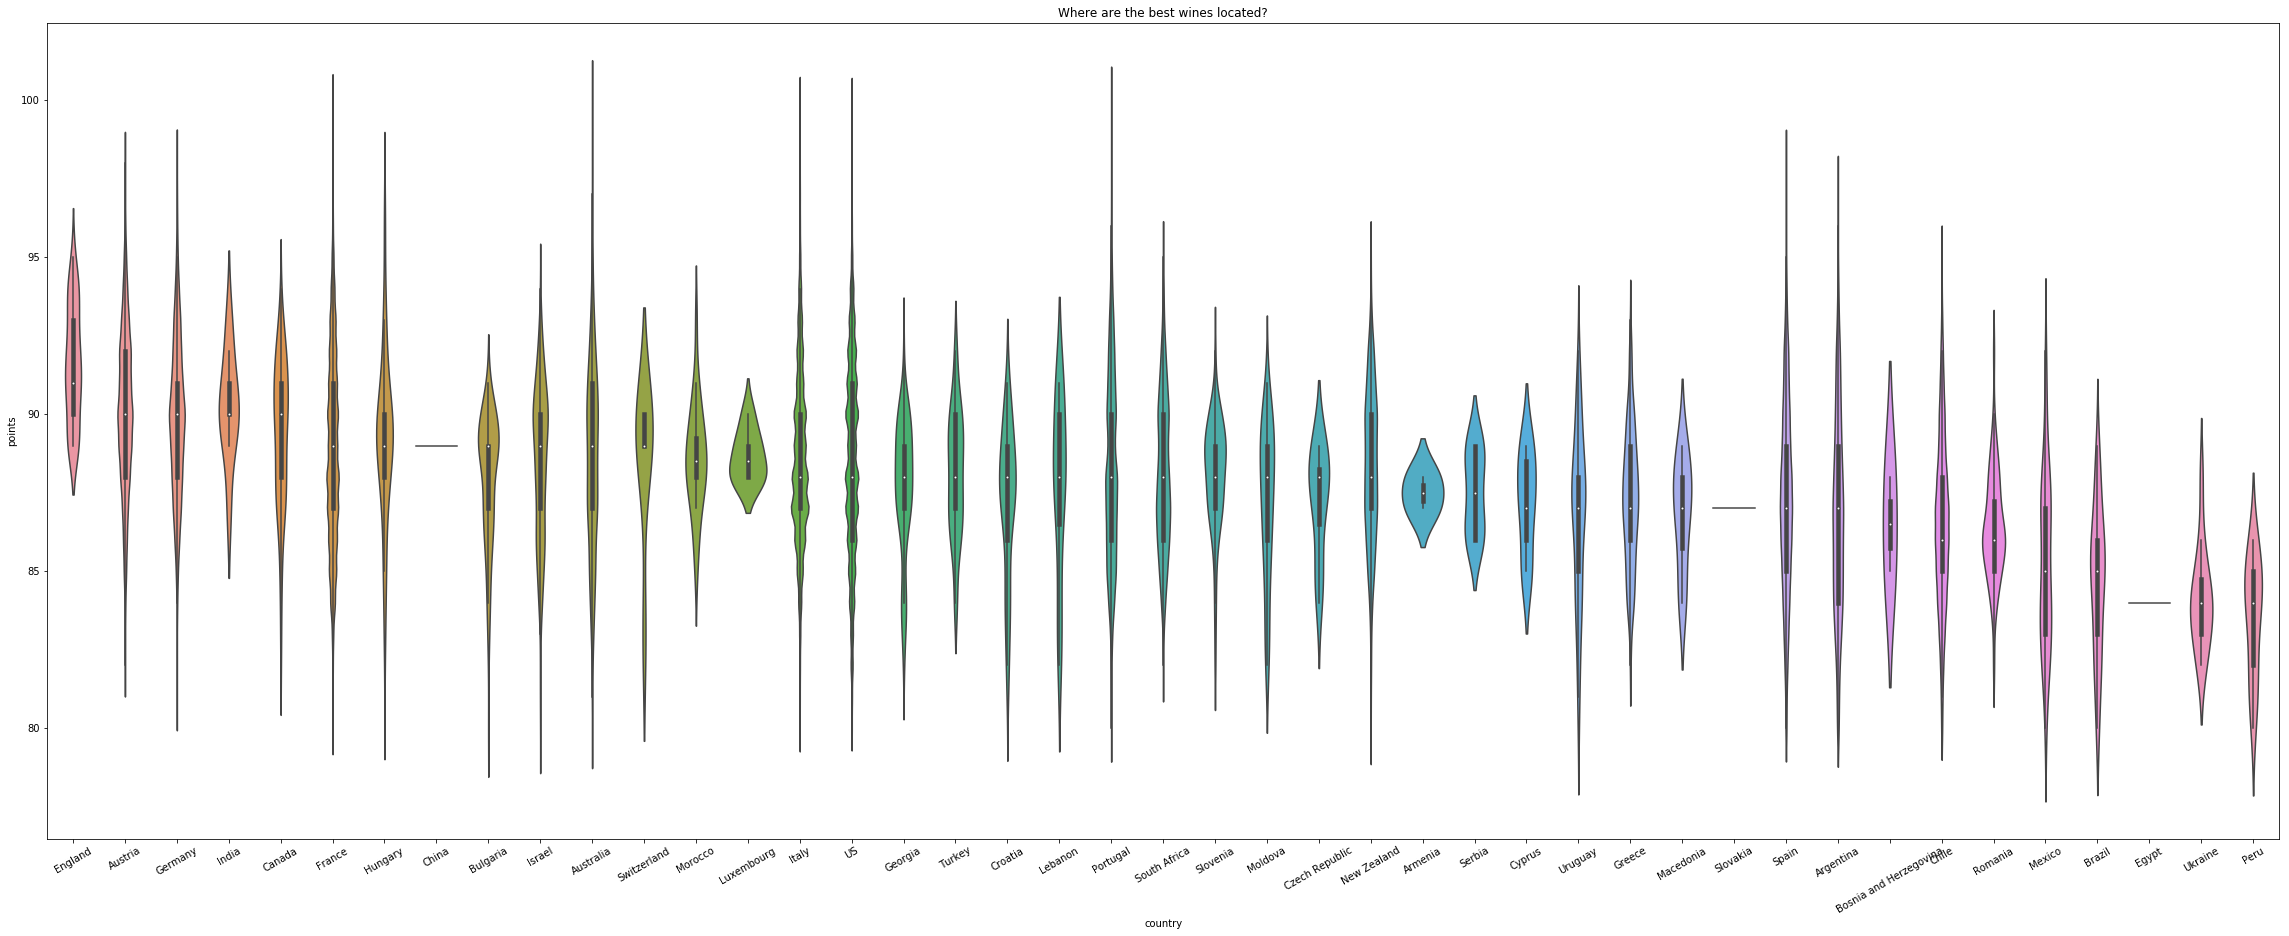

In [4]:
# violin plot of country and points
plt.figure(figsize=(40,15))
decOrder = winereviews.groupby(by=["country"])["points"].median().sort_values(ascending=False).index
vplot = sns.violinplot(data=winereviews,x='country',y='points',order=decOrder)
vplot.set_xticklabels(labels = vplot.get_xticklabels(), rotation=30)
plt.title('Where are the best wines located?')

When people think of wine they think of France. Here I explore the distribution of wines across various countries using a violin plot. These plots are ordered by the median. Surprisingly, France is not the top based on its median, but we can see that the distribution range is very long. England is the country with the highest median. We do see a gradual decrease in the medians of wine price. However, the distributions have various ranges.

Here we encode violinplots to compare distributions. As we've learned, using boxplots for multiple distribution comparisons can be misleading. I encode color here as a redundant way to identify the countries. The mark we use is an area for the violinplots as we are not only concerned with the length of the distribution, but also where in the distribution a majority of the reviews are located. I also use a point mark for the median to identify the median. The channel I encode for the violin plot is primarily position. The same is for the points.

### Dataset preprocessing

After further inspection of the data set, my computer several errors when attempting to manipulate the non-text data. I attribute this to the sparsity of the dataset. However, in its raw form, trying to convert the dataframe from sparse to dense proved to be very difficult

In [5]:

winereviews.drop(['title'],axis=1,inplace=True)

In [6]:
# set low frequency values with an other token
winereviews['variety'] = np.where(winereviews['variety'].isin(winereviews['variety'].value_counts().loc[winereviews['variety'].value_counts()<=5].index),'Other',winereviews['variety'])
winereviews['winery'] = np.where(winereviews['winery'].isin(winereviews['winery'].value_counts().loc[winereviews['winery'].value_counts()<=5].index),'Other',winereviews['winery'])
winereviews['region_1'] = np.where(winereviews['region_1'].isin(winereviews['region_1'].value_counts().loc[winereviews['region_1'].value_counts()<=5].index),'Other',winereviews['region_1'])
winereviews['province'] = np.where(winereviews['province'].isin(winereviews['province'].value_counts().loc[winereviews['province'].value_counts()<=5].index),'Other',winereviews['province'])
winereviews['region_2'] = np.where(winereviews['region_2'].isin(winereviews['region_2'].value_counts().loc[winereviews['region_2'].value_counts()<=5].index),'Other',winereviews['region_2'])
winereviews['designation'] = np.where(winereviews['designation'].isin(winereviews['designation'].value_counts().loc[winereviews['designation'].value_counts()<=5].index),'Other',winereviews['designation'])





In [7]:
X_train, X_test, y_train, y_test = train_test_split(winereviews.drop('points',axis=1),winereviews['points'],test_size=0.2)

In [8]:
# get the mean of quantitative variables by the mean of wine from each country
meanPrice = X_train.groupby('country').mean().reset_index().rename(columns={'price':'mean price'})

# do on train data
X_train = X_train.merge(meanPrice,how='left',on='country')
X_train['price'] = np.where(pd.isna(X_train['price']),X_train['mean price'],X_train['price'])
X_train.drop('mean price',axis=1,inplace=True)
X_train['price'] = np.log(X_train['price'])
X_train['price'] = X_train['price'].fillna(0)

# do on test data
X_test = X_test.merge(meanPrice,how='left',on='country')
X_test['price'] = np.where(pd.isna(X_test['price']),X_test['mean price'],X_test['price'])
X_test.drop('mean price',axis=1,inplace=True)
X_test['price'] = np.log(X_test['price'])

In [9]:
X_train['price'] = X_train['price'].fillna(0)
X_test['price'] = X_test['price'].fillna(0)

In [10]:
# compare the pearson correlation coefficient for both log transform of price and no log transform

slopeLog, interceptLog, r_valueLog, p_valueLog, std_errLog = linregress(x=np.log(winereviews['price'].loc[pd.notna(winereviews['price'])]),y=winereviews['points'].loc[pd.notna(winereviews['price'])])
slope, intercept, r_value, p_value, std_err = linregress(x=winereviews['price'].loc[pd.notna(winereviews['price'])],y=winereviews['points'].loc[pd.notna(winereviews['price'])])

print((r_valueLog, p_valueLog),(r_value,p_value))

(0.6118495019831404, 0.0) (0.4161667418606225, 0.0)


In [11]:
# remove taster information 
X_train.drop(['taster_name','taster_twitter_handle'],axis=1,inplace=True)
X_test.drop(['taster_name','taster_twitter_handle'],axis=1,inplace=True)
X_train

,country,description,designation,price,province,region_1,region_2,variety,winery
0,France,"This is a light, slightly herbal blend of one-...",Other,2.772589,Provence,Côtes de Provence,NaN,White Blend,Other
1,US,This bottling from Brack Mountain Wine Company...,NaN,3.555348,California,Santa Lucia Highlands,Central Coast,Chardonnay,Other
2,France,"A full-bodied, mouthfilling rosé from the Côte...",Réserve Grand Veneur,2.564949,Rhône Valley,Côtes du Rhône,NaN,Rosé,Alain Jaume et Fils
3,US,From a single sustainably farmed vineyard in L...,Cherokee Lane,2.397895,California,Lodi,Central Valley,Cabernet Sauvignon,Tortoise Creek
4,Italy,"Made with Nebbiolo and Pinot Nero, this delive...",Other,3.688879,Italy Other,Vino Spumante,NaN,Red Blend,Rivetti Massimo
5,US,"This dry, full-bodied wine has lots of rich, e...",NaN,3.912023,California,Santa Cruz Mountains,Central Coast,Cabernet Sauvignon,Martin Ray
6,US,"Although it has a delicate structure, that fee...",Other,3.688879,New York,Finger Lakes,Finger Lakes,Riesling,Fox Run
7,France,"A smooth, finely balanced wine with a soft tex...",Other,3.714699,Provence,Côtes de Provence,NaN,Rosé,Les Maîtres Vignerons de Saint-Louis
8,Spain,"Charred, earthy black-fruit aromas are smoky a...",Crianza,2.708050,Northern Spain,Rioja,NaN,Tempranillo,Other
9,Italy,"This blend of Cannonau, Carignano and Bovale o...",Other,3.828641,Sicily & Sardinia,Isola dei Nuraghi,NaN,Red Blend,Pala


These charts show the number of null values for these two columns, region_1 and region_2. What we see is that for region 1, a large majority of the records are not nan. However, in region 2 we see that a majority (60%) of the records are null values. 

I also look at the individual differences in the distributions of no location vs a specified location for each region variable. We see little difference betwee both groups. 

In [12]:
# extract descriptions to be set aside.

trainDesc = X_train['description'].copy(deep=True)
testDesc = X_test['description'].copy(deep=True)

X_train.drop('description',axis=1,inplace=True)
X_test.drop('description',axis=1,inplace=True)

In [13]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

It seems as though there are certain variables with very specific values are causing different dimensionality between the training and test set. So we add a column for every variable in the training set that isn't the test set and remove the columns that are not in the training set but are in the test set.

In [14]:
for col in list(set(X_train.columns).difference(set(X_test.columns))): # add columns from train set to test set
    X_test[col]=0

In [15]:
X_test.drop(list(set(X_test.columns).difference(set(X_train.columns))),axis=1,inplace=True) # remove columns from test that are not in train.

In [16]:
dummy_cols = list(X_train.columns)

In [17]:
X_test = X_test[list(X_train.columns)] # sort columnts

In [18]:
list(X_test.columns) == list(X_train.columns)

True

### Text Processing

Reviews will provide a lot of insight regarding how good a wine is. We need to preprocess the data by following these steps. 

1. Tokenize the data.
2. Remove stop words
2. Create tf-idf matrix where the documents are each description 

In [19]:
def textPreprocessing(data):
    dataCopy= data.copy(deep=True)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    dataCopy = dataCopy.str.lower()
    translator = str.maketrans('', '', string.punctuation)

    dataCopy = dataCopy.apply(lambda x: x.translate(translator))
    dataCopy = dataCopy.apply(lambda x: pattern.sub('',x))
    #dataCopy = dataCopy.apply(lambda x: word_tokenize(x))
    return dataCopy.values

trainPreprocessed = textPreprocessing(trainDesc)
testPreprocessed = textPreprocessing(testDesc)



In [20]:
tfidf = TfidfVectorizer()
tfidf.fit(trainPreprocessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
train_tfidf = tfidf.transform(trainPreprocessed)
test_tfidf = tfidf.transform(testPreprocessed)

In [22]:
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)

In [24]:
X_train_sparse = hstack((X_train_sparse,train_tfidf))
X_test_sparse = hstack((X_test_sparse,test_tfidf))

## SVD

We can use SVD to get dense representations of our data. This will speed up computation and perhaps uncover interesting relationships within the tf-idf matrix.

In [21]:
def numComponentsSVD(data,n=6000):
    svd = TruncatedSVD(n_components=n)
    svd.fit(data)
    sns.lineplot(x=list(range(1,n+1)),y=np.cumsum(svd.explained_variance_ratio_))

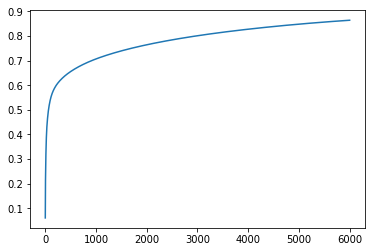

In [22]:
numComponentsSVD(X_train_sparse)

This plot shows cumulative proportion for the explained variance. It seems we reach 80% explained variance a little after 3000, so let's use 3200 as the number of components for our dataset.

In [23]:
svd = TruncatedSVD(n_components=3200)
svd.fit(X_train_sparse)
trainSVD = svd.transform(X_train_sparse)
testSVD = svd.transform(X_test_sparse)

## Models

I was not able to get the models to run for this homework assignment due to several instances of memory errors. Like the notes on Piazza suggested, I originally tried keeping everything in sparse matrices/dataframes. However, the pandas get dummies function does not create dummy variables for sparse dataframes (even when sparse=true.) I then tried to move my work to the cloud and got an instance with 50+GB but was still unable to get around the memory errors. If possible, in the feedback could you mention what is the best way to get around this? 

I picked three regression models: lasso, ridge and ElasticNet. ElasticNet gets the benefits of both Lasso and Ridge so I included it to compare the others. I wanted to see how the L1 norm and L2 norm specifically faired on extremely sparse datasets and if there was some insight to be made regarding simply using the manhattan distance for modeling regression based on sparse inputs.

In [34]:
lasso_RS = RandomizedSearchCV(estimator=Lasso(),param_distributions={'alpha':np.random.rand(100)*10},n_iter=20,scoring='mean_absolute_error',cv=10)
ridge_RS = RandomizedSearchCV(estimator=Ridge(),param_distributions={'alpha':np.random.rand(100)*10},n_iter=20,scoring='mean_absolute_error',cv=10)
elastic_RS = RandomizedSearchCV(estimator=ElasticNet(),param_distributions={'alpha':np.random.rand(100)*10},n_iter=20,scoring='mean_absolute_error',cv=10)

In [35]:
lasso_RS.fit(trainSVD,y_train)
ridge_RS.fit(trainSVD,y_train)
elastic_RS.fit(trainSVD,y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'alpha': array([5.53619, 1.14797, ..., 0.21808, 2.17345])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='mean_absolute_error',
          verbose=0)

For this assignment I chose to use three variations of linear regression. The reason I chose this was primarily for efficiency reasons. While algorithms such as XGBoost and SVR may provide better results, the training time for them is generally very long. I chose to stay away from tree based regressors because they can overfit. While general regression is a simple algorithm, it benefits from a shorter training times. Rather than having multiple hyperparameters to tune, there really is only one parameter, alpha, to tune. Alpha is the regularization constant. 

I learn the model by using random search. Random search empirically has shown to get close to the optimal hyperparameters settings in less computations. While grid search might get a better result, since it has to go through all iterations, it will lend itself to being computationally exhaustive. I used mean absolute error as my metric for optimization. This is because we want to know how close we get per review in terms of accuracy. Things like root mean squared error or mean squared error might not show those results as clearly. 

In [36]:
lrsRes = pd.DataFrame(lasso_RS.cv_results_)
rrsRes = pd.DataFrame(ridge_RS.cv_results_)
ersRes = pd.DataFrame(elastic_RS.cv_results_)

[Text(0,0,'LASSO'), Text(0,0,'RIDGE'), Text(0,0,'ELASTICNET')]

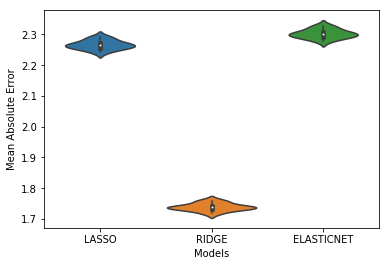

In [65]:
g=sns.violinplot(data=np.vstack(( # need to flip sign because random search function returns loss not actual MAE
            np.negative(lrsRes.loc[lrsRes['rank_test_score']==1][[x for x in lrsRes.columns if 'test' in x and 'split' in x]].values[0]),
              np.negative(rrsRes.loc[rrsRes['rank_test_score']==1][[x for x in rrsRes.columns if 'test' in x and 'split' in x]].values[0]),
              np.negative(ersRes.loc[ersRes['rank_test_score']==1][[x for x in ersRes.columns if 'test' in x and 'split' in x]].values[0]))).T)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
g.set_xticklabels(['LASSO','RIDGE','ELASTICNET'])

We find that on average, Ridge Regression is off by 1.7 points and Lasso and ElasticNet are almost 2.3 points off away. On a scale of one to ten. We will use Ridge Regression as the model of choice for the final algorithm. In this plot we use violin plots to compare the distribution of scores between the three models. We encode the color channel for identifying the three modelsand and the position channel to compare the different models. We use an area mark to compare the shapes of the distributions and a point to identify the median. This is on a rectilinear axis.

In [67]:
# actual model

model = Ridge(alpha=ridge_RS.best_params_['alpha'])
model.fit(trainSVD,y_train)
y_pred = model.predict(testSVD)
mean_absolute_error(y_true=y_test,y_pred=y_pred)

1.728466813886363

Text(0.5,1,'Principal Components with the Highest Regression Coefficient')

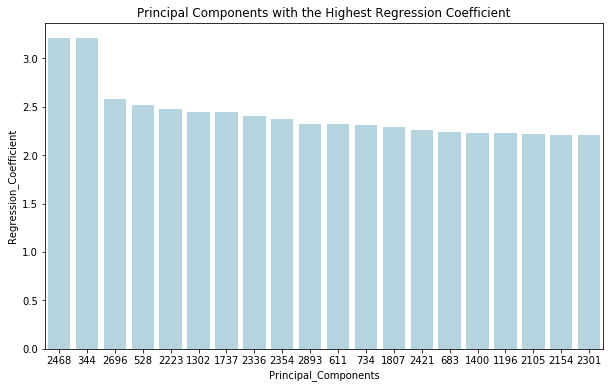

In [98]:
coefs = pd.Series(np.abs(model.coef_)).reset_index().rename(columns={'index':'Principal_Components',0:'Regression_Coefficient'})
coefs['Principal_Components']=coefs['Principal_Components'].apply(str)
coefs = coefs.sort_values('Regression_Coefficient',ascending=False)[:20]
plt.figure(figsize=(10,6))
sns.barplot(data=coefs,x='Principal_Components',y='Regression_Coefficient',order=coefs['Principal_Components'],color='lightblue')
plt.title('Principal Components with the Highest Regression Coefficient')

Plotting regression coefficients isn't the best way to get the feature importances of a model as the coefficients are not standardized. However, given the fact that getting the z-scores of all features and dependent values would be a time consuming task (we would have to redo svd) these are the high regression coefficients.

We encode the length magnitude channel to compare the different principal components. The mark used here is a line. Finally this is on a rectilinear axis.